In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

from common.training import *
from common.utils import load_sql_to_df, save_to_sql, plot_history

import datasets
import data_process as dp
from models import SentimentAnalysisLSTM

import numpy as np
import pandas as pd
import sqlite3 as db
import torchtext
import torch
import torch.utils
import matplotlib.pyplot as plt

2023-03-29 23:37:35.259475: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-29 23:37:36.552908: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-03-29 23:37:36.553432: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-03-

In [2]:
#reproducibility
# torch.manual_seed(0)
# random.seed(0)
# np.random.seed(0)

## Load data

In [3]:
important_columns = ["position", "move", "comment", "sentiment"]
moves_df = load_sql_to_df("SELECT * FROM english_annotated_moves", "../../chess.db")[important_columns]
moves_df

,position,move,comment,sentiment
0,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,e2e4,This is my first gameknot game against someone...,2
1,rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBN...,b1c3,"I've been playing the Vienna Gambit as white, ...",-1
2,rnbqkbnr/pppp1ppp/8/4p3/4P3/2N5/PPPP1PPP/R1BQK...,f8c5,Minor disappointment.,-1
3,r1bqk2r/pppp1ppp/2n2n2/2b1p3/2B1P3/2NP4/PPP2PP...,f2f4,"My idea here is to expand on the kingside, dri...",-1
4,r1bqk2r/ppp2ppp/3p1n2/n1b1pP2/2B1P3/2NP4/PPP3P...,d1f3,"Maybe this isn't the greatest plan, since with...",0
...,...,...,...,...
326634,rnb5/p2p1P1N/7p/1pR5/6P1/4k3/2P1B3/3Q1RK1 b - ...,b5b4,Pawn,-1
326635,rnb5/p2p1P1N/7p/2R5/1p4P1/4k3/2P1B3/3Q1RK1 w -...,f7f8q,Check mate in two moves,-1
326636,rnb2Q2/p2p3N/7p/2R5/1p4P1/4k3/2P1B3/3Q1RK1 b -...,d7d6,Pawn,-1
326637,rnb2Q2/p6N/3p3p/2R5/1p4P1/4k3/2P1B3/3Q1RK1 w -...,f8e8,Check,-1


## Preprocessing

In [4]:
glove_embbedings = torchtext.vocab.GloVe(name="6B", dim=200, cache="../../.vector_cache/")
datasets.add_padding_vector_to_embeddings(glove_embbedings)

In [5]:
comments_df = dp.prepare_data_for_sentiment_analysis_training(moves_df, glove_embbedings.stoi, max_len=150)
comments_df

,comment,sentiment,preprocessed_comment
14871,again pointless,0,"[again, pointless]"
7856,!! hahaha,1,"[!, !]"
17139,strong.,1,"[strong, .]"
17938,oversight.,0,"[oversight, .]"
13952,offers exchange,1,"[offer, exchange]"
...,...,...,...
19600,"tom played this to break the pin. but, it is a...",0,"[tom, play, this, to, break, the, pin, ., but,..."
6617,"?? in this position, i was worried about losin...",0,"[?, ?, in, this, position, ,, be, worried, abo..."
5662,?? black has ideas of immediately attacking th...,0,"[?, ?, black, have, idea, of, immediately, att..."
18734,this is where i make a mistake of only calcula...,0,"[this, be, where, make, a, mistake, of, only, ..."


In [6]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [7]:
train_df, test_df = dp.df_train_test_split(comments_df, comment_col='preprocessed_comment', test_size=0.1)
display(train_df)
display(test_df)

,comment,sentiment,preprocessed_comment
13968,white blunders,0,"[white, blunder]"
16154,again weak,0,"[again, weak]"
18823,blunder!,0,"[blunder, !]"
19576,prophylaxis?,1,"[prophylaxis, ?]"
10948,direct.,1,"[direct, .]"
...,...,...,...
18556,"but, magnus castled, instead. so, i said, it's...",0,"[but, ,, magnus, castle, ,, instead, ., so, ,,..."
17546,"i was not intending to win a pawn, here, as it...",0,"[be, not, intend, to, win, a, pawn, ,, here, ,..."
6617,"?? in this position, i was worried about losin...",0,"[?, ?, in, this, position, ,, be, worried, abo..."
4762,"?? in this position, he is attacking and threa...",0,"[?, ?, in, this, position, ,, he, be, attack, ..."


,comment,sentiment,preprocessed_comment
16966,this!,1,"[this, !]"
2261,? i thought,0,"[?, think]"
12426,unwise.,0,"[unwise, .]"
11516,qe8#,0,"[qe8, #]"
9942,stoping king,1,"[stop, king]"
...,...,...,...
18158,"of course, black has other ideas which is why ...",0,"[of, course, ,, black, have, other, idea, whic..."
9820,"?? joe didn't say anything until now. but, aft...",0,"[?, ?, joe, do, not, say, anything, until, now..."
18234,i understand this move very well as black thou...,0,"[understand, this, move, very, well, as, black..."
19600,"tom played this to break the pin. but, it is a...",0,"[tom, play, this, to, break, the, pin, ., but,..."


In [8]:
train_dataset = datasets.PretrainedEmbeddingsIndicesDataset(train_df, glove_embbedings, comment_col='preprocessed_comment')
test_dataset = datasets.PretrainedEmbeddingsIndicesDataset(test_df, glove_embbedings,  comment_col='preprocessed_comment')

## Comments' length

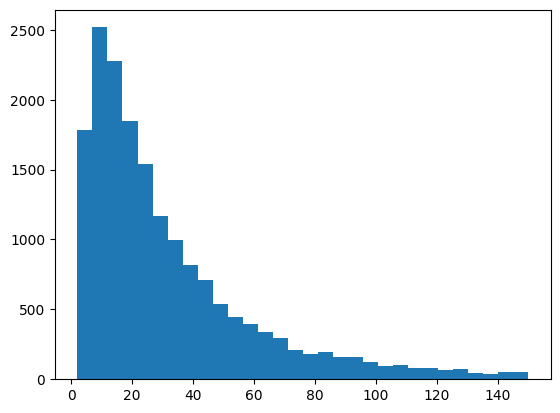

In [9]:
lengths = [len(x) for x,_ in train_dataset]
plt.hist(lengths, bins=30)
plt.show()

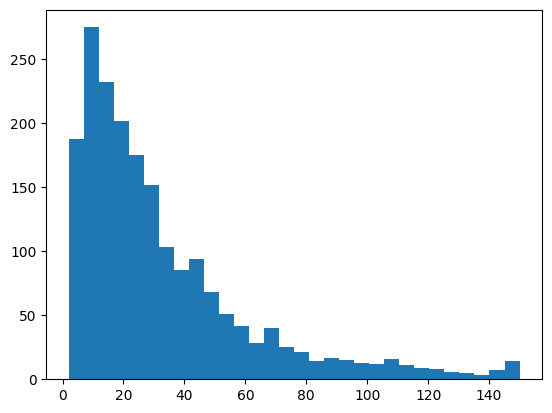

In [10]:
lengths = [len(x) for x,_ in test_dataset]
plt.hist(lengths, bins=30)
plt.show()

## Training

In [11]:
train_loader = datasets.DataLoaderPadding(dataset=train_dataset, batch_size=64)
test_loader = datasets.DataLoaderPadding(dataset=test_dataset, batch_size=64)

In [24]:
model = SentimentAnalysisLSTM(embeddings=glove_embbedings, hidden_dim=256, num_layers=3, dropout=0.5)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [25]:
history = train_loop(train_loader, model, optimizer, val_dataloader=test_loader, num_epochs=50, verbose=True)

Epoch 1/50
Train loss: 0.424844, accuracy: 80.81%
Val loss:  0.591891, accuracy: 74.57%
-----------------------------
Epoch 2/50
Train loss: 0.348344, accuracy: 83.97%
Val loss:  0.507658, accuracy: 80.53%
-----------------------------
Epoch 3/50
Train loss: 0.354717, accuracy: 84.26%
Val loss:  0.429305, accuracy: 83.89%
-----------------------------
Epoch 4/50
Train loss: 0.298358, accuracy: 85.76%
Val loss:  0.361566, accuracy: 80.68%
-----------------------------
Epoch 5/50
Train loss: 0.286163, accuracy: 86.20%
Val loss:  0.296763, accuracy: 87.73%
-----------------------------
Epoch 6/50
Train loss: 0.253986, accuracy: 88.24%
Val loss:  0.261442, accuracy: 88.40%
-----------------------------
Epoch 7/50
Train loss: 0.272983, accuracy: 87.52%
Val loss:  0.301462, accuracy: 84.26%
-----------------------------
Epoch 8/50
Train loss: 0.244994, accuracy: 88.42%
Val loss:  0.259420, accuracy: 88.09%
-----------------------------
Epoch 9/50
Train loss: 0.238141, accuracy: 88.78%
Val lo

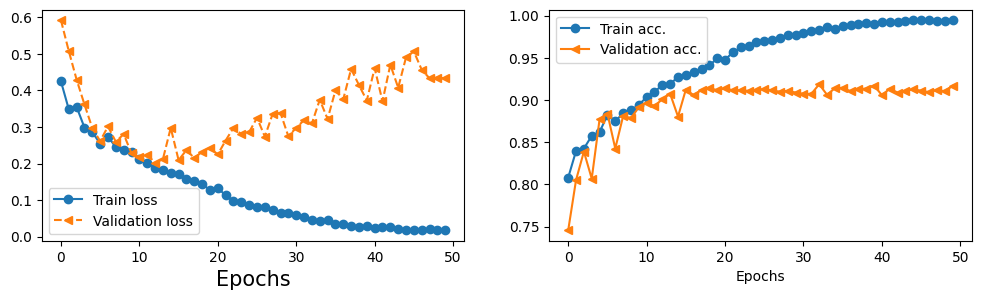

In [28]:
plot_history(history)

In [33]:
model_2 = SentimentAnalysisLSTM(embeddings=glove_embbedings, hidden_dim=128, num_layers=2, dropout=0.5)
model_2 = model_2.to(device)
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)
history_2 = train_loop(train_loader, model_2, optimizer, val_dataloader=test_loader, num_epochs=50, verbose=True)

Epoch 1/50
Train loss: 0.345552, accuracy: 83.85%
Val loss:  0.382158, accuracy: 81.20%
-----------------------------
Epoch 2/50
Train loss: 0.367538, accuracy: 83.29%
Val loss:  0.741585, accuracy: 61.52%
-----------------------------
Epoch 3/50
Train loss: 0.331752, accuracy: 83.29%
Val loss:  0.508776, accuracy: 60.38%
-----------------------------
Epoch 4/50
Train loss: 0.290864, accuracy: 86.28%
Val loss:  0.313971, accuracy: 81.56%
-----------------------------
Epoch 5/50
Train loss: 0.305918, accuracy: 86.73%
Val loss:  0.494015, accuracy: 81.10%
-----------------------------
Epoch 6/50
Train loss: 0.265187, accuracy: 88.05%
Val loss:  0.240423, accuracy: 89.59%
-----------------------------
Epoch 7/50
Train loss: 0.239186, accuracy: 89.00%
Val loss:  0.228620, accuracy: 89.85%
-----------------------------
Epoch 8/50
Train loss: 0.229132, accuracy: 89.53%
Val loss:  0.225269, accuracy: 89.80%
-----------------------------
Epoch 9/50
Train loss: 0.222286, accuracy: 89.94%
Val lo

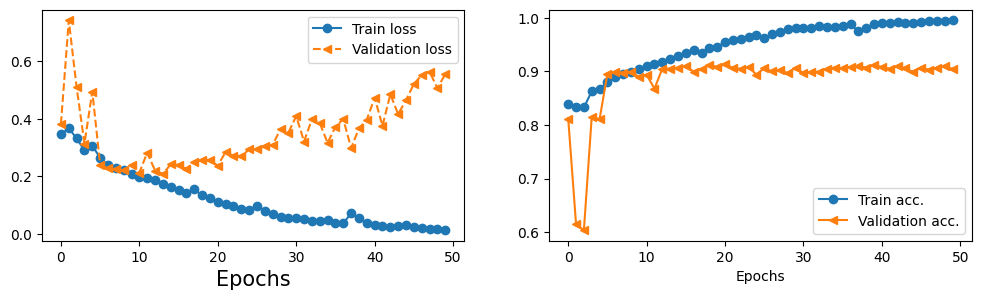

In [37]:
plot_history(history_2)

In [21]:
model_3 = SentimentAnalysisLSTM(embeddings=glove_embbedings, hidden_dim=128, num_layers=3, dropout=0.2, bidirectional=True)
model_3 = model_3.to(device)
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001, weight_decay=0.001)
history_3 = train_loop(train_loader, model_3, optimizer, val_dataloader=test_loader, num_epochs=50, verbose=True)

Epoch 1/50
Train loss: 0.419865, accuracy: 79.61%
Val loss:  0.439491, accuracy: 81.98%
-----------------------------
Epoch 2/50
Train loss: 0.328901, accuracy: 84.45%
Val loss:  0.331464, accuracy: 81.77%
-----------------------------
Epoch 3/50
Train loss: 0.336212, accuracy: 84.48%
Val loss:  0.543447, accuracy: 70.69%
-----------------------------
Epoch 4/50
Train loss: 0.320366, accuracy: 85.31%
Val loss:  0.333909, accuracy: 84.83%
-----------------------------
Epoch 5/50
Train loss: 0.293744, accuracy: 86.78%
Val loss:  0.585718, accuracy: 63.39%
-----------------------------
Epoch 6/50
Train loss: 0.290259, accuracy: 86.54%
Val loss:  0.320275, accuracy: 85.91%
-----------------------------
Epoch 7/50
Train loss: 0.270150, accuracy: 88.02%
Val loss:  0.297941, accuracy: 84.72%
-----------------------------
Epoch 8/50
Train loss: 0.254348, accuracy: 88.71%
Val loss:  0.280810, accuracy: 85.60%
-----------------------------
Epoch 9/50
Train loss: 0.249427, accuracy: 88.94%
Val lo

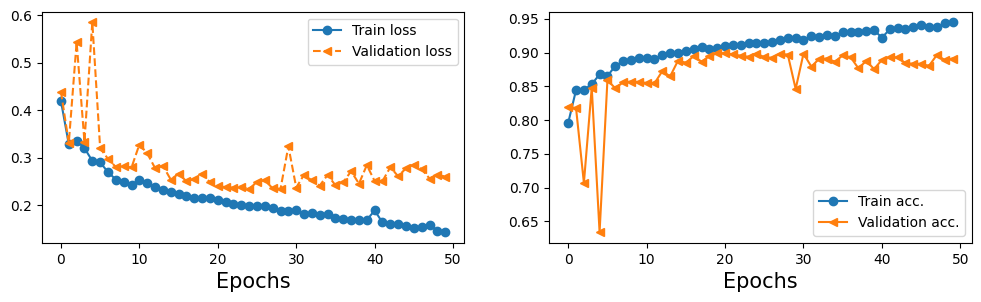

In [22]:
plot_history(history_3)

In [25]:
torch.save(model.state_dict(), "../../models/LSTM_glove200_60ep.model")
model.load_state_dict(torch.load("../../models/LSTM_glove200_60ep.model"))
model = model.to(device)

## Testing

In [23]:
test_model(test_loader, model_3)

Test Error: Accuracy: 89.12%, Avg loss: 0.260597


In [27]:
test_model(train_loader, model)

Test Error: 
 Accuracy: 99.7%, Avg loss: 0.007981 



In [36]:
boundary = 0.01

In [19]:
test_high_confidence(test_loader, model_3, low_boundary=0.01)

High confidence samples: 1394/1931 = 72.19%
Accuracy for high confidence samples: 97.1%


In [38]:
all_moves_df = load_sql_to_df("SELECT * FROM english_annotated_moves", "../../chess.db",)[important_columns]
all_moves_df

,position,move,comment,sentiment
0,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,e2e4,This is my first gameknot game against someone...,2
1,rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBN...,b1c3,"I've been playing the Vienna Gambit as white, ...",-1
2,rnbqkbnr/pppp1ppp/8/4p3/4P3/2N5/PPPP1PPP/R1BQK...,f8c5,Minor disappointment.,-1
3,r1bqk2r/pppp1ppp/2n2n2/2b1p3/2B1P3/2NP4/PPP2PP...,f2f4,"My idea here is to expand on the kingside, dri...",-1
4,r1bqk2r/ppp2ppp/3p1n2/n1b1pP2/2B1P3/2NP4/PPP3P...,d1f3,"Maybe this isn't the greatest plan, since with...",0
...,...,...,...,...
326634,rnb5/p2p1P1N/7p/1pR5/6P1/4k3/2P1B3/3Q1RK1 b - ...,b5b4,Pawn,-1
326635,rnb5/p2p1P1N/7p/2R5/1p4P1/4k3/2P1B3/3Q1RK1 w -...,f7f8q,Check mate in two moves,-1
326636,rnb2Q2/p2p3N/7p/2R5/1p4P1/4k3/2P1B3/3Q1RK1 b -...,d7d6,Pawn,-1
326637,rnb2Q2/p6N/3p3p/2R5/1p4P1/4k3/2P1B3/3Q1RK1 w -...,f8e8,Check,-1


In [39]:
moves_df_with_preprocessed_comments = dp.prepare_data_for_sentiment_analysis_prediction(all_moves_df, glove_embbedings.stoi)
moves_df_with_preprocessed_comments

,position,move,comment,sentiment,preprocessed_comment
81251,r1bqkbnr/pp1p1ppp/2n5/2p1p3/7P/2NP3R/PPP1PPP1/...,d7d5,so i did d7-d5,-1,"[so, do]"
139666,r2q1rk1/pp2bppp/2p1pnb1/4N1B1/2Q5/3P2N1/PPP2PP...,f6d5,Possible was 13. ... Qd5! 14. Nxg6 fg! 15.Qh4 h6,-1,"[possible, be]"
222593,8/2P2pkp/6p1/pP6/P3r1P1/6KP/4pP2/4R3 b - - 0 40,e4c4,Only move,-1,"[only, move]"
231547,8/8/8/8/5K2/6Q1/7k/8 b - - 14 63,h2h1,Only move,-1,"[only, move]"
46704,rnbqkbnr/pp1ppppp/8/2p5/4P3/8/PPPP1PPP/RNBQKBN...,f1c4,and....,-1,"[and, ....]"
...,...,...,...,...,...
265121,8/3b4/2p2kp1/pp2p2p/4P3/1P1P1NP1/P1P4P/6K1 w -...,d3d4,"? Knowing that I'm still a pawn up, I, once ag...",0,"[?, know, that, be, still, a, pawn, up, once, ..."
170837,r2qk2r/ppp2ppp/2np4/2b1p2b/4P3/2NP1N1P/PPP2PP1...,c3d5,"Since he does not make the capture, I do not k...",-1,"[since, he, do, not, make, the, capture, do, n..."
121703,r5k1/7p/1qn5/p1p2QP1/P7/1N5P/1bP5/3R3K w - - 1 30,d1d7,Threatening checkmate. The only defense to thi...,-1,"[threaten, checkmate, ., the, only, defense, t..."
26749,r4r1k/p5q1/bp2p1B1/2ppP3/6R1/2P3P1/PPQ2b1N/R6K...,f2e3,"I stop the threat, while preparing to get my b...",-1,"[stop, the, threat, while, prepare, to, get, m..."


In [25]:
moves_df_with_preprocessed_comments = moves_df_with_preprocessed_comments.reset_index()
moves_df_with_preprocessed_comments

,index,position,move,comment,sentiment,preprocessed_comment
0,0,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,e2e4,This is my first gameknot game against someone...,2,"[this, be, my, first, game, against, someone, ..."
1,1,rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBN...,b1c3,"I've been playing the Vienna Gambit as white, ...",-1,"['ve, be, play, the, vienna, gambit, as, white..."
2,2,rnbqkbnr/pppp1ppp/8/4p3/4P3/2N5/PPPP1PPP/R1BQK...,f8c5,Minor disappointment.,-1,"[minor, disappointment, .]"
3,3,r1bqk2r/pppp1ppp/2n2n2/2b1p3/2B1P3/2NP4/PPP2PP...,f2f4,"My idea here is to expand on the kingside, dri...",-1,"[my, idea, here, be, to, expand, on, the, king..."
4,4,r1bqk2r/ppp2ppp/3p1n2/n1b1pP2/2B1P3/2NP4/PPP3P...,d1f3,"Maybe this isn't the greatest plan, since with...",0,"[maybe, this, be, not, the, great, plan, since..."
...,...,...,...,...,...,...
309464,326606,rnb5/ppppk2N/2n4p/3Nb3/5qP1/P4P2/1PP1B3/R2Q1RK...,e7d6,Black left their queen hanging so I can take i...,-1,"[black, leave, their, queen, hang, so, can, ta..."
309465,326607,rnb5/pppp3N/2nk3p/3Nb3/5qP1/P4P2/1PP1B3/R2Q1RK...,d5f4,Takes queen,-1,"[take, queen]"
309466,326625,rnb5/pppp3N/7p/1R3P2/4k1P1/8/2P1B3/3Q1RK1 w - ...,f5f6,Right here when I starting if I can get pawn t...,-1,"[right, here, when, start, if, can, get, pawn,..."
309467,326629,rnb5/pp1p3N/2p2P1p/8/1R4P1/4k3/2P1B3/3Q1RK1 w ...,f6f7,Almost to other side,-1,"[almost, to, other, side]"


In [40]:
unlabeled_dataset = datasets.PretrainedEmbeddingsIndicesDataset(moves_df_with_preprocessed_comments, glove_embbedings, comment_col="preprocessed_comment")
unlabeled_loader = datasets.DataLoaderPadding(dataset=unlabeled_dataset, batch_size = 128)
predictions = predict(unlabeled_loader, model, low_boundary=0.1)
moves_df_with_preprocessed_comments.loc[:, "sentiment"] = predictions.numpy().astype(np.int32)
# moves_df_with_preprocessed_comments[moves_df_with_preprocessed_comments.sentiment.isin([0,1])]
moves_df_with_preprocessed_comments

,position,move,comment,sentiment,preprocessed_comment
81251,r1bqkbnr/pp1p1ppp/2n5/2p1p3/7P/2NP3R/PPP1PPP1/...,d7d5,so i did d7-d5,-1,"[so, do]"
139666,r2q1rk1/pp2bppp/2p1pnb1/4N1B1/2Q5/3P2N1/PPP2PP...,f6d5,Possible was 13. ... Qd5! 14. Nxg6 fg! 15.Qh4 h6,0,"[possible, be]"
222593,8/2P2pkp/6p1/pP6/P3r1P1/6KP/4pP2/4R3 b - - 0 40,e4c4,Only move,1,"[only, move]"
231547,8/8/8/8/5K2/6Q1/7k/8 b - - 14 63,h2h1,Only move,1,"[only, move]"
46704,rnbqkbnr/pp1ppppp/8/2p5/4P3/8/PPPP1PPP/RNBQKBN...,f1c4,and....,1,"[and, ....]"
...,...,...,...,...,...
265121,8/3b4/2p2kp1/pp2p2p/4P3/1P1P1NP1/P1P4P/6K1 w -...,d3d4,"? Knowing that I'm still a pawn up, I, once ag...",0,"[?, know, that, be, still, a, pawn, up, once, ..."
170837,r2qk2r/ppp2ppp/2np4/2b1p2b/4P3/2NP1N1P/PPP2PP1...,c3d5,"Since he does not make the capture, I do not k...",0,"[since, he, do, not, make, the, capture, do, n..."
121703,r5k1/7p/1qn5/p1p2QP1/P7/1N5P/1bP5/3R3K w - - 1 30,d1d7,Threatening checkmate. The only defense to thi...,1,"[threaten, checkmate, ., the, only, defense, t..."
26749,r4r1k/p5q1/bp2p1B1/2ppP3/6R1/2P3P1/PPQ2b1N/R6K...,f2e3,"I stop the threat, while preparing to get my b...",1,"[stop, the, threat, while, prepare, to, get, m..."


In [45]:
classified_comments = moves_df_with_preprocessed_comments[moves_df_with_preprocessed_comments.sentiment.isin([0,1])].reset_index()
classified_comments

,index,position,move,comment,sentiment,preprocessed_comment
0,139666,r2q1rk1/pp2bppp/2p1pnb1/4N1B1/2Q5/3P2N1/PPP2PP...,f6d5,Possible was 13. ... Qd5! 14. Nxg6 fg! 15.Qh4 h6,0,"[possible, be]"
1,222593,8/2P2pkp/6p1/pP6/P3r1P1/6KP/4pP2/4R3 b - - 0 40,e4c4,Only move,1,"[only, move]"
2,231547,8/8/8/8/5K2/6Q1/7k/8 b - - 14 63,h2h1,Only move,1,"[only, move]"
3,46704,rnbqkbnr/pp1ppppp/8/2p5/4P3/8/PPPP1PPP/RNBQKBN...,f1c4,and....,1,"[and, ....]"
4,3084,r1q1r1k1/pp3pp1/2p2n2/2Nn3p/1PQN2b1/6P1/P2RPP1...,a7a6,Defensive.,1,"[defensive, .]"
...,...,...,...,...,...,...
272591,265121,8/3b4/2p2kp1/pp2p2p/4P3/1P1P1NP1/P1P4P/6K1 w -...,d3d4,"? Knowing that I'm still a pawn up, I, once ag...",0,"[?, know, that, be, still, a, pawn, up, once, ..."
272592,170837,r2qk2r/ppp2ppp/2np4/2b1p2b/4P3/2NP1N1P/PPP2PP1...,c3d5,"Since he does not make the capture, I do not k...",0,"[since, he, do, not, make, the, capture, do, n..."
272593,121703,r5k1/7p/1qn5/p1p2QP1/P7/1N5P/1bP5/3R3K w - - 1 30,d1d7,Threatening checkmate. The only defense to thi...,1,"[threaten, checkmate, ., the, only, defense, t..."
272594,26749,r4r1k/p5q1/bp2p1B1/2ppP3/6R1/2P3P1/PPQ2b1N/R6K...,f2e3,"I stop the threat, while preparing to get my b...",1,"[stop, the, threat, while, prepare, to, get, m..."


In [53]:
con = db.connect("../../chess.db")
classified_comments.sentiment =  pd.to_numeric(classified_comments.sentiment)
classified_comments_to_save = classified_comments[['position', 'move', 'comment', 'sentiment']]
classified_comments_to_save.to_sql('classified_moves', con, if_exists='replace')

272596